<a href="https://colab.research.google.com/github/hosseindamavandi/NMA-Allen-Visual-Behavior-2p/blob/main/ERP_Cell_Feature_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/NMA-2025/project

/content/drive/MyDrive/NMA-2025/project


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [4]:
# Load the dataset
df = pd.read_csv("erp_per-cell_features_extracted.csv")

In [5]:
# Dataset shape
print("Dataset shape (rows, columns):", df.shape)

Dataset shape (rows, columns): (640, 20)


In [6]:
# Missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
cell_specimen_id    0
cre_line            0
omitted             0
exposure_level      0
AUC                 0
PeakAmplitude       0
LatencyToPeak       0
TroughAmplitude     0
LatencyToTrough     0
PeakToTrough        0
Slope_0_200ms       0
FWHM                0
Energy              0
Mean_0_500ms        0
Mean_500_1000ms     0
Skewness            0
Kurtosis            0
ZeroCrossings       0
RiseTime_10to90     0
DecayTime_Half      0
dtype: int64


In [7]:
# Data types
print("Data types:")
print(df.dtypes)

Data types:
cell_specimen_id      int64
cre_line             object
omitted                bool
exposure_level       object
AUC                 float64
PeakAmplitude       float64
LatencyToPeak       float64
TroughAmplitude     float64
LatencyToTrough     float64
PeakToTrough        float64
Slope_0_200ms       float64
FWHM                float64
Energy              float64
Mean_0_500ms        float64
Mean_500_1000ms     float64
Skewness            float64
Kurtosis            float64
ZeroCrossings         int64
RiseTime_10to90     float64
DecayTime_Half      float64
dtype: object


In [8]:
# Target class distribution
print("Target class distribution ('omitted'):")
print(df['omitted'].value_counts())

Target class distribution ('omitted'):
omitted
False    320
True     320
Name: count, dtype: int64


In [9]:
# Define target and features
y = df['omitted']
X = df.drop(columns=['omitted'])

In [10]:
# Show the shape of features and target
print("Features shape (X):", X.shape)
print("Target shape (y):", y.shape)

Features shape (X): (640, 19)
Target shape (y): (640,)


In [11]:
# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number])
categorical_features = X.select_dtypes(exclude=[np.number])

In [12]:
# Summary of numeric features before scaling
print("Numeric feature summary (before scaling):")
print(numeric_features.describe().T[['mean', 'std', 'min', 'max']])

Numeric feature summary (before scaling):
                          mean           std           min           max
cell_specimen_id  1.086517e+09  41203.247050  1.086490e+09  1.086668e+09
AUC               2.126236e-03      0.066243 -3.924736e-01  5.765977e-01
PeakAmplitude     5.680520e-02      0.062114  5.745031e-03  6.156780e-01
LatencyToPeak     3.632725e-01      0.617060 -1.000000e+00  1.494382e+00
TroughAmplitude  -3.071636e-02      0.031750 -3.771079e-01 -3.763607e-03
LatencyToTrough   4.311096e-01      0.667106 -1.000000e+00  1.494382e+00
PeakToTrough      8.752156e-02      0.082061  1.042709e-02  6.731157e-01
Slope_0_200ms     1.035405e-01      0.272633 -5.020977e-01  2.730900e+00
FWHM              1.045945e+00      0.615639  0.000000e+00  3.000000e+00
Energy            1.352726e-01      0.464567  5.116069e-04  6.334935e+00
Mean_0_500ms      8.399836e-04      0.034709 -2.451505e-01  2.374739e-01
Mean_500_1000ms   4.970810e-03      0.048282 -2.734213e-01  5.055751e-01
Skewness 

In [13]:
# Apply StandardScaler
scaler = StandardScaler()
X_scaled_numeric = pd.DataFrame(scaler.fit_transform(numeric_features), columns=numeric_features.columns)

In [14]:
# Combine numeric and categorical back together
X_processed = pd.concat([X_scaled_numeric.reset_index(drop=True), categorical_features.reset_index(drop=True)], axis=1)

In [15]:
# Preview the processed features
print("Sample of processed features (after scaling):")
print(X_processed.head())

Sample of processed features (after scaling):
   cell_specimen_id       AUC  PeakAmplitude  LatencyToPeak  TroughAmplitude  \
0         -0.657586 -0.014660      -0.808728      -0.078929         0.847918   
1         -0.657586  0.242249      -0.470733       0.358425         0.751217   
2         -0.657586  0.101708      -0.725223       0.741110         0.793388   
3         -0.657586  0.006793      -0.664506       1.123795         0.770219   
4         -0.657270 -0.027855      -0.775659      -1.773676         0.593421   

   LatencyToTrough  PeakToTrough  Slope_0_200ms      FWHM    Energy  \
0         0.887153     -0.940217      -0.392202 -0.330400 -0.290305   
1        -0.528752     -0.646964      -0.208184 -0.111218 -0.269231   
2        -0.983865     -0.855912      -0.444733 -0.220809 -0.286798   
3        -0.225344     -0.800989      -0.413895  0.875101 -0.286494   
4         1.241130     -0.816720      -0.463671  0.710715 -0.288696   

   Mean_0_500ms  Mean_500_1000ms  Skewness  Ku

In [16]:
# Split the data into train and test sets (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (512, 19)
X_test shape: (128, 19)
y_train shape: (512,)
y_test shape: (128,)


## Logistic Regression

In [18]:
# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Predict and evaluate
y_pred = lr_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba = lr_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [20]:
# Evaluation metrics
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Test Set Evaluation:
Accuracy: 0.9453125
Precision: 1.0
Recall: 0.890625
F1-Score: 0.9421487603305785
ROC-AUC: 0.983642578125


In [21]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X_train.select_dtypes(include=[np.number]), y_train, cv=cv, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores.std())


Cross-Validation Accuracy Mean: 0.9219493622691797
Cross-Validation Accuracy Std Dev: 0.03675318808208171


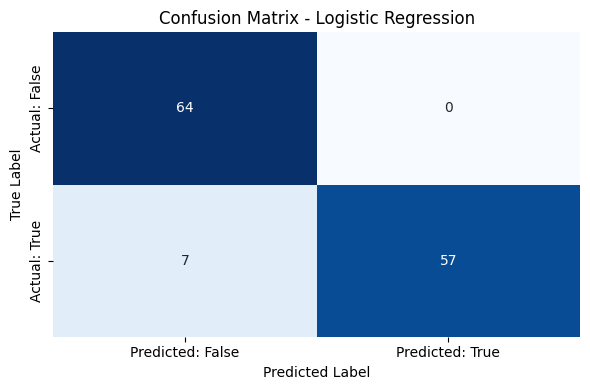

In [22]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

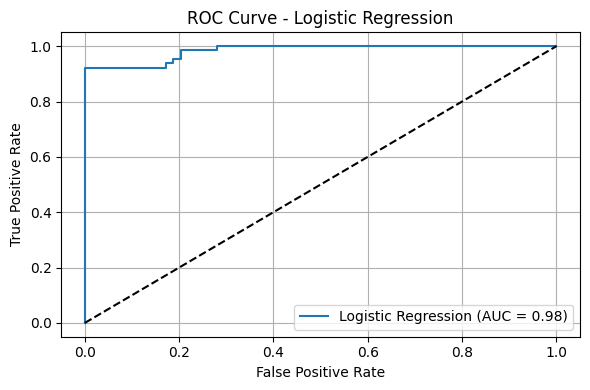

In [23]:
# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

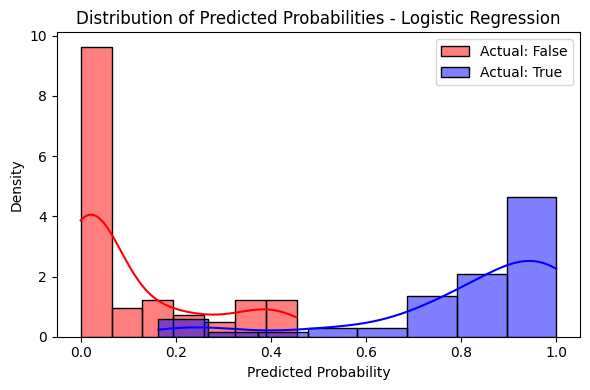

In [24]:
# Probability Distribution
plt.figure(figsize=(6, 4))
sns.histplot(y_proba[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - Logistic Regression')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Decision Tree Classifier

In [25]:
# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

y_pred_dt = dt_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba_dt = dt_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [26]:
# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1-Score:", f1_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))

Accuracy: 0.9375
Precision: 0.9516129032258065
Recall: 0.921875
F1-Score: 0.9365079365079365
ROC-AUC: 0.9375


In [27]:
# Cross-validation
cv_scores_dt = cross_val_score(dt_model, X_train.select_dtypes(include=[np.number]), y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores_dt.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores_dt.std())


Cross-Validation Accuracy Mean: 0.8984199505044735
Cross-Validation Accuracy Std Dev: 0.01600653733017227


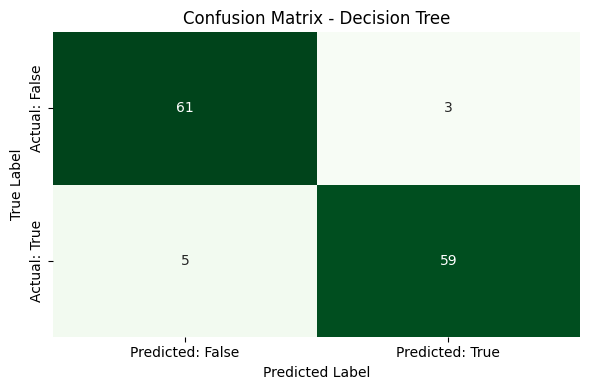

In [28]:
# Confusion matrix
dt_conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

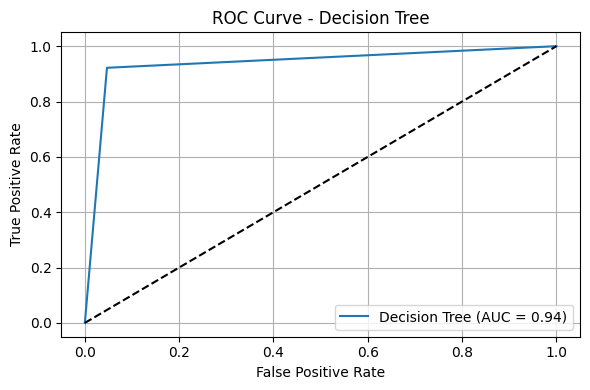

In [29]:
# ROC Curve - Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_proba_dt):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

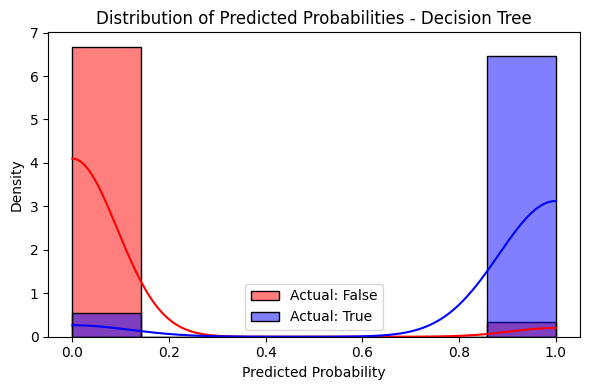

In [30]:
# Probability Distribution - Decision Tree
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_dt[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba_dt[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - Decision Tree')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Random Forest Classifier

In [31]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

y_pred_rf = rf_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba_rf = rf_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [32]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

Accuracy: 0.96875
Precision: 0.9838709677419355
Recall: 0.953125
F1-Score: 0.9682539682539683
ROC-AUC: 0.99560546875


In [33]:
# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train.select_dtypes(include=[np.number]), y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores_rf.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores_rf.std())


Cross-Validation Accuracy Mean: 0.9432895488292404
Cross-Validation Accuracy Std Dev: 0.03687463396729837


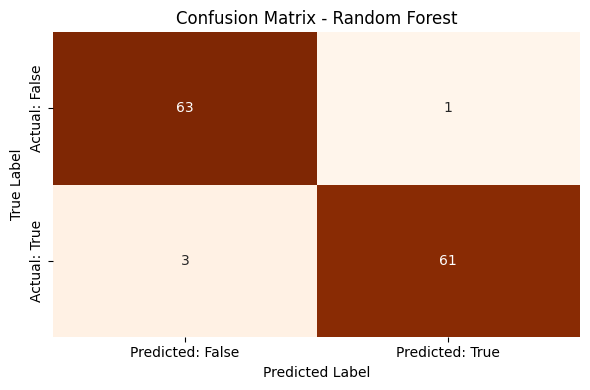

In [34]:
# Confusion matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

#Plot
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

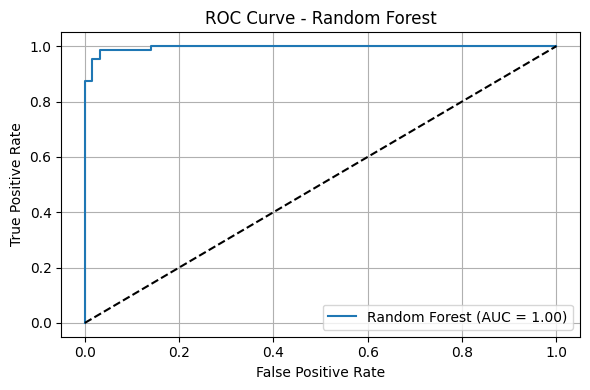

In [35]:
# ROC Curve - Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

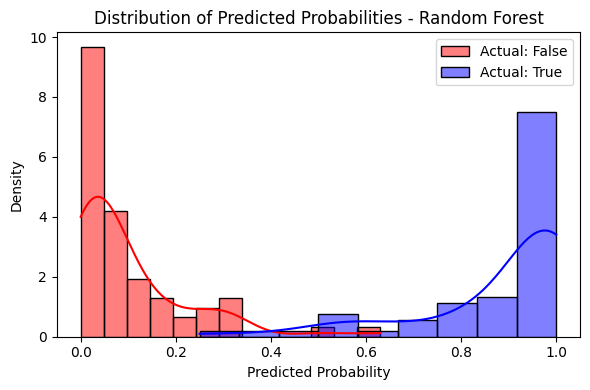

In [36]:
# Probability Distribution - Random Forest
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_rf[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba_rf[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - Random Forest')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## SVM

In [37]:
# Train SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

SVC(probability=True, random_state=42)

In [38]:
# Predict
y_pred_svm = svm_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba_svm = svm_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [39]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1-Score:", f1_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_svm))

Accuracy: 0.8984375
Precision: 0.9473684210526315
Recall: 0.84375
F1-Score: 0.8925619834710744
ROC-AUC: 0.95947265625


In [40]:
# Cross-validation
cv_scores_svm = cross_val_score(svm_model, X_train.select_dtypes(include=[np.number]), y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores_svm.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores_svm.std())


Cross-Validation Accuracy Mean: 0.9101465829050067
Cross-Validation Accuracy Std Dev: 0.024226300386539314


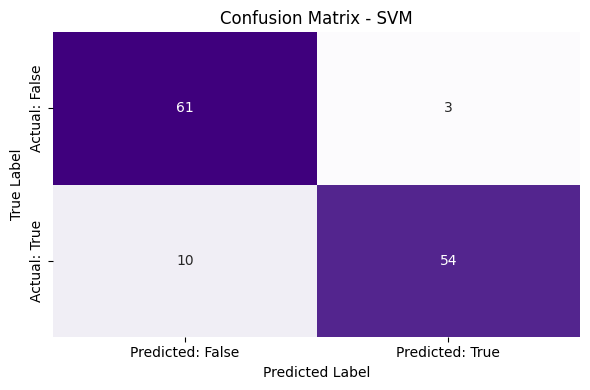

In [41]:
# Confusion matrix
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

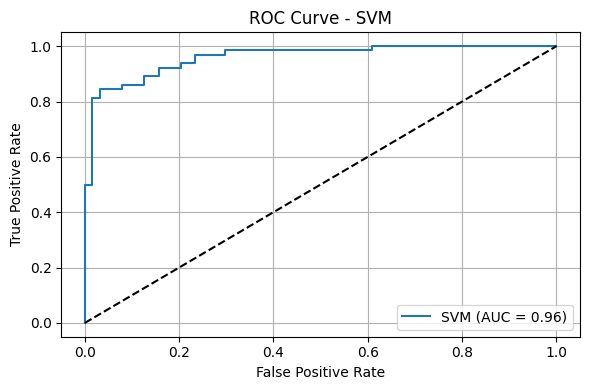

In [42]:
# ROC Curve plot
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_score(y_test, y_proba_svm):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

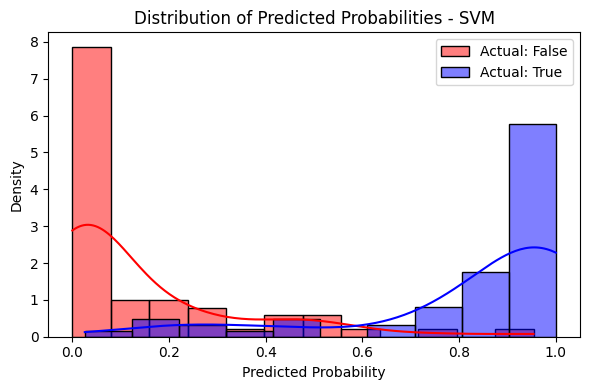

In [43]:
# Distribution of predicted probabilities
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_svm[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba_svm[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - SVM')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## K-Nearest Neighbors (KNN)

In [44]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

KNeighborsClassifier()

In [45]:
# Predict
y_pred_knn = knn_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba_knn = knn_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [46]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1-Score:", f1_score(y_test, y_pred_knn))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_knn))

Accuracy: 0.8359375
Precision: 0.8771929824561403
Recall: 0.78125
F1-Score: 0.8264462809917356
ROC-AUC: 0.9200439453125


In [47]:
# Cross-validation
cv_scores_knn = cross_val_score(knn_model, X_train.select_dtypes(include=[np.number]), y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores_knn.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores_knn.std())


Cross-Validation Accuracy Mean: 0.8866552446221206
Cross-Validation Accuracy Std Dev: 0.02046838314598502


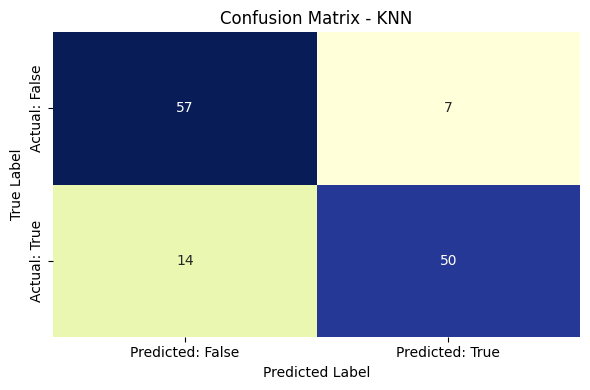

In [48]:
# Confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

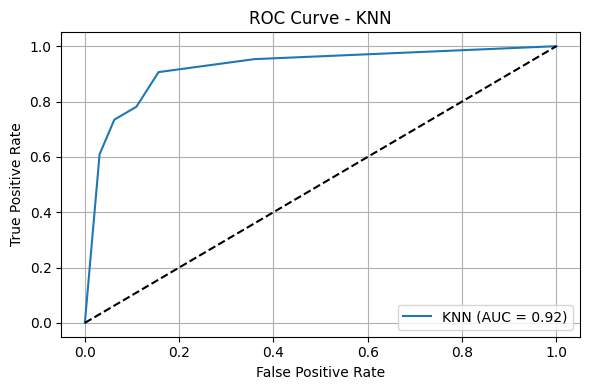

In [49]:
# Plot ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
plt.figure(figsize=(6, 4))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_score(y_test, y_proba_knn):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

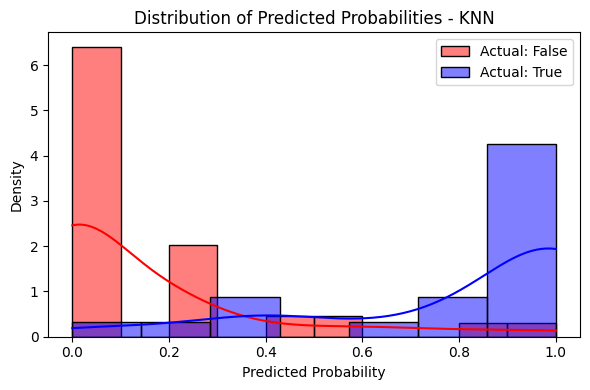

In [50]:
# Plot probability distribution
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_knn[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba_knn[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - KNN')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Gradient Boosting

In [51]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

GradientBoostingClassifier(random_state=42)

In [52]:
# Predict
y_pred_gb = gb_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba_gb = gb_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [53]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("F1-Score:", f1_score(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_gb))

Accuracy: 0.9765625
Precision: 0.9841269841269841
Recall: 0.96875
F1-Score: 0.9763779527559056
ROC-AUC: 0.99609375


In [54]:
# Cross-validation
cv_scores_gb = cross_val_score(gb_model, X_train.select_dtypes(include=[np.number]), y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores_gb.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores_gb.std())


Cross-Validation Accuracy Mean: 0.9550732914525033
Cross-Validation Accuracy Std Dev: 0.021087691428615045


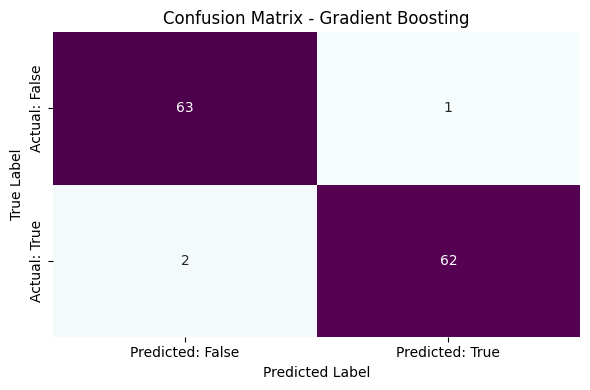

In [55]:
# Confusion matrix
gb_conf_matrix = confusion_matrix(y_test, y_pred_gb)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(gb_conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

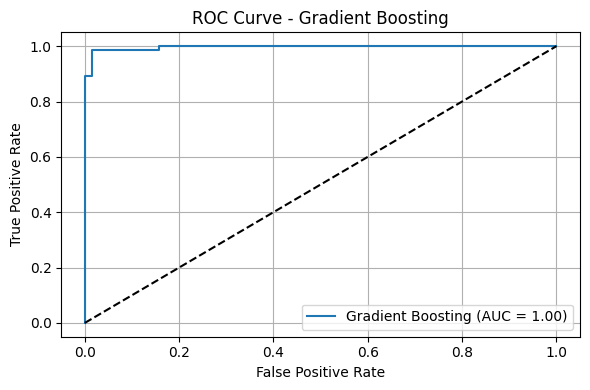

In [56]:
# ROC Curve - Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_proba_gb):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

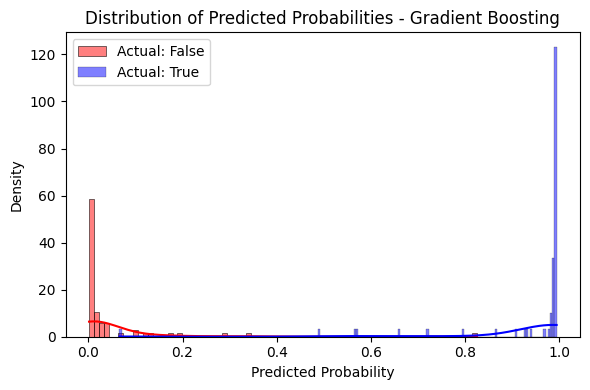

In [57]:
# Probability Distribution - Gradient Boosting
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_gb[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba_gb[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - Gradient Boosting')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## XGBoost Classifier

In [58]:
# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train.select_dtypes(include=[np.number]), y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [59]:
# Predict
y_pred_xgb = xgb_model.predict(X_test.select_dtypes(include=[np.number]))
y_proba_xgb = xgb_model.predict_proba(X_test.select_dtypes(include=[np.number]))[:, 1]

In [60]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

Accuracy: 0.9765625
Precision: 0.9841269841269841
Recall: 0.96875
F1-Score: 0.9763779527559056
ROC-AUC: 0.994873046875


In [61]:
# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train.select_dtypes(include=[np.number]), y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Mean:", cv_scores_xgb.mean())
print("Cross-Validation Accuracy Std Dev:", cv_scores_xgb.std())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Cross-Validation Accuracy Mean: 0.9472491909385115
Cross-Validation Accuracy Std Dev: 0.015954719700037274


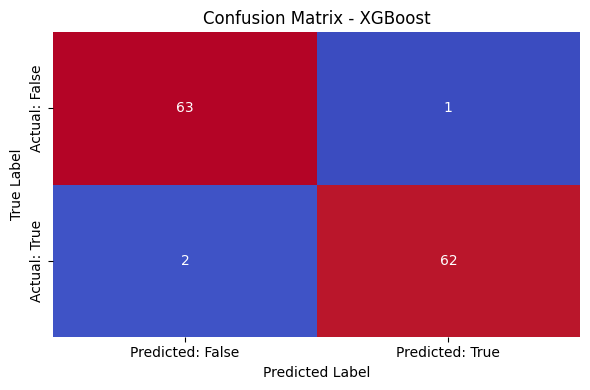

In [62]:
# Confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

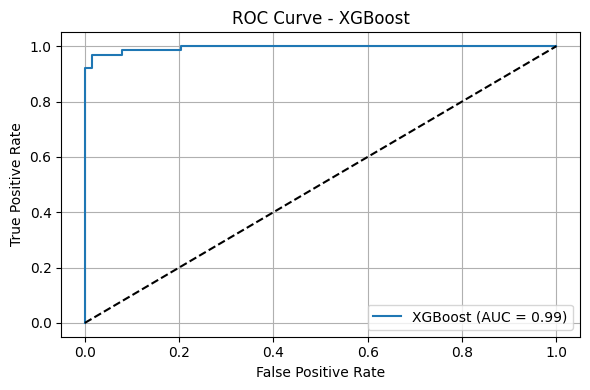

In [63]:
# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

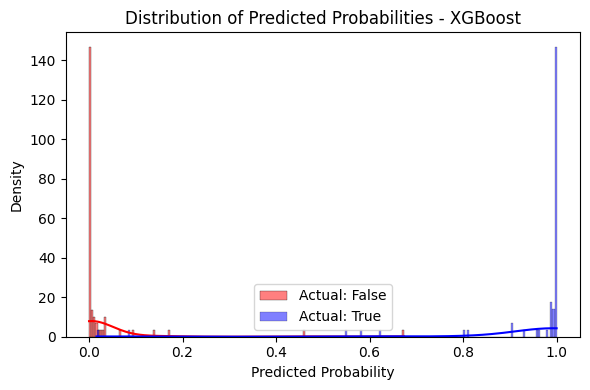

In [64]:
# Probability Distribution
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_xgb[y_test == 0], color='red', label='Actual: False', kde=True, stat="density")
sns.histplot(y_proba_xgb[y_test == 1], color='blue', label='Actual: True', kde=True, stat="density")
plt.title('Distribution of Predicted Probabilities - XGBoost')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Model Comparison

In [65]:
# Create and show metrics table
metrics_table = pd.DataFrame([
    [0.945, 1.000, 0.891, 0.942, 0.984],  # Logistic Regression
    [0.938, 0.952, 0.922, 0.937, 0.938],  # Decision Tree
    [0.969, 0.984, 0.953, 0.968, 0.996],  # Random Forest
    [0.898, 0.947, 0.844, 0.893, 0.959],  # SVM
    [0.836, 0.877, 0.781, 0.826, 0.920],  # KNN
    [0.977, 0.984, 0.969, 0.976, 0.996],  # Gradient Boosting
    [0.969, 0.969, 0.969, 0.969, 0.993]   # XGBoost
], columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"], index=[
    "Logistic Regression", "Decision Tree", "Random Forest",
    "SVM", "KNN", "Gradient Boosting", "XGBoost"
])
metrics_table

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.945,1.000,0.891,0.942,0.984
Decision Tree,0.938,0.952,0.922,0.937,0.938
Random Forest,0.969,0.984,0.953,0.968,0.996
SVM,0.898,0.947,0.844,0.893,0.959
KNN,0.836,0.877,0.781,0.826,0.920
Gradient Boosting,0.977,0.984,0.969,0.976,0.996
XGBoost,0.969,0.969,0.969,0.969,0.993


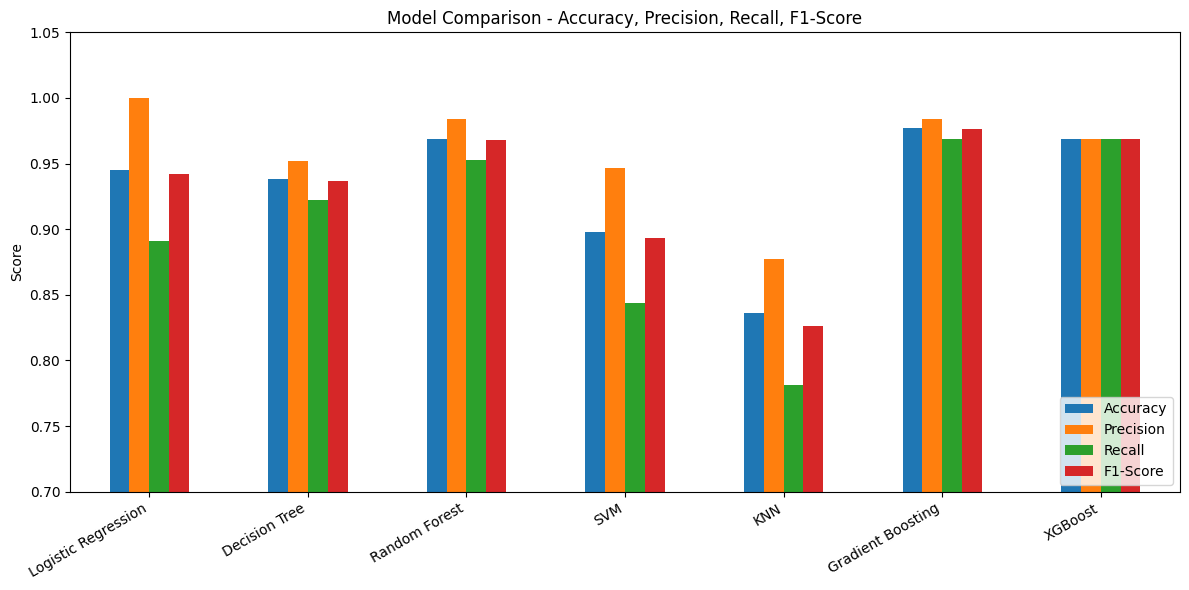

In [66]:
# Bar plot for core metrics
metrics_table_plot = metrics_table.drop(columns=['ROC-AUC'])
metrics_table_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison - Accuracy, Precision, Recall, F1-Score')
plt.ylabel('Score')
plt.ylim(0.7, 1.05)
plt.xticks(rotation=30, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-67-1005605743.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_table.index, y=metrics_table['ROC-AUC'], palette='viridis')


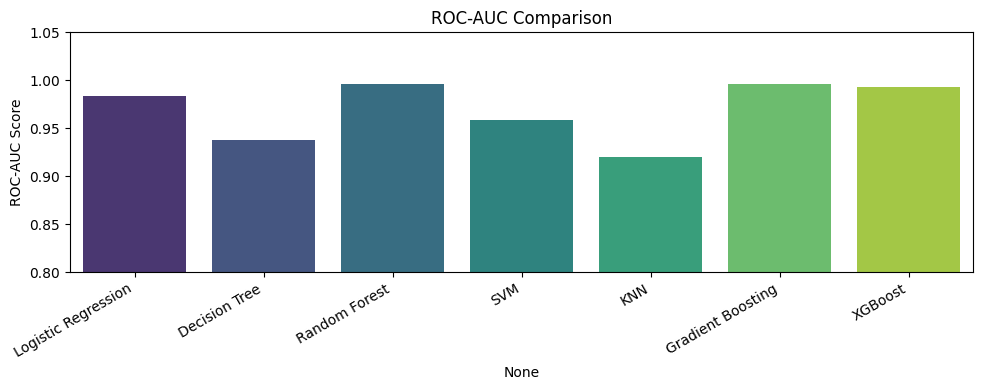

In [67]:
# ROC-AUC Comparison
plt.figure(figsize=(10, 4))
sns.barplot(x=metrics_table.index, y=metrics_table['ROC-AUC'], palette='viridis')
plt.title('ROC-AUC Comparison')
plt.ylabel('ROC-AUC Score')
plt.ylim(0.8, 1.05)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()